In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


In [2]:
df = pd.read_pickle('df.plk')
df.shape

(1050, 16)

#### On souhaite associer à chaque image une catégorie cible

In [3]:
df_to_merge = df[['target','image']].copy()
df_to_merge.head()

,target,image
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


#### On créer un df avec le chemin vers les images

In [29]:
from sklearn import preprocessing

# Chemin 
path = "./Données/Flipkart/images"
path_test = "./Données/Flipkart/images"

# Liste d'images
list_labels = df.image.tolist()
label_no_name = "no_name "


def photo_class(photo) :
    for label in list_labels :
        if label in photo[24:] : 
            return label
    return label_no_name
    
data_path = glob(path+'*/*.jp*')
#data_test_path = glob(path_test+'*/*.jp*')

def data_fct(path) :
    list_photos = [file for file in path] # boucle sur photos
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["image"] = data["image_path"].apply(lambda x : photo_class(x))
    return data

data = data_fct(data_path)
#data_test = data_fct(data_test_path)

# On vérifie si les photos sont bien les mêmes
if (set(data['image'].unique()) == set(df['image'].unique())) == True:
    print('Les images des deux dataframes correspondent')

1050
1050
Les images des deux dataframes correspondent


In [91]:
# Jointure pour récupérer la colonne target
data = df_to_merge.merge(data, on = 'image')

# Encodage pour modélisation 
le = preprocessing.LabelEncoder()
le.fit(data["target"])
data["target_encode"] = le.transform(data["target"])

# Visualisation du df
data.head()

,target,image,image_path,target_encode
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,./Données/Flipkart\Images\55b85ea15a1536d46b71...,4
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,./Données/Flipkart\Images\7b72c92c2f6c40268628...,0
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,./Données/Flipkart\Images\64d5d4a258243731dc7b...,0
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,./Données/Flipkart\Images\d4684dcdc759dd9cdf41...,4
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,./Données/Flipkart\Images\6325b6870c54cd47be6e...,4


In [6]:
target_list = data.target.unique().tolist()
target_list

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [7]:
# for t in target_list:
#     f(list_{t}) = t

Home Furnishing


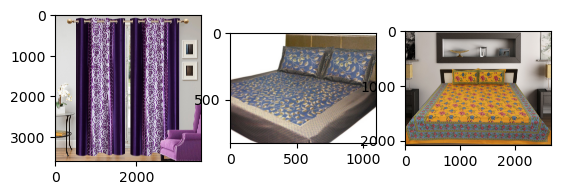

Baby Care


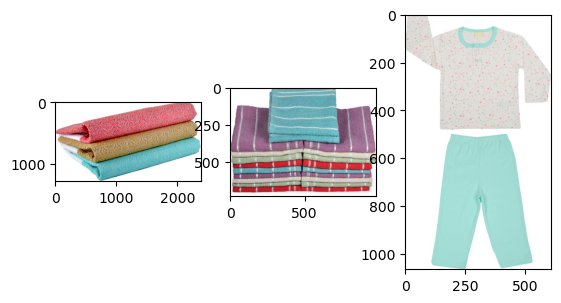

Watches


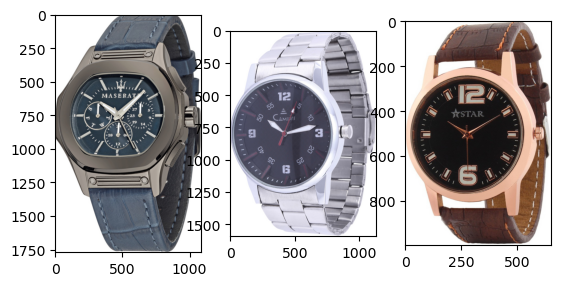

Home Decor & Festive Needs


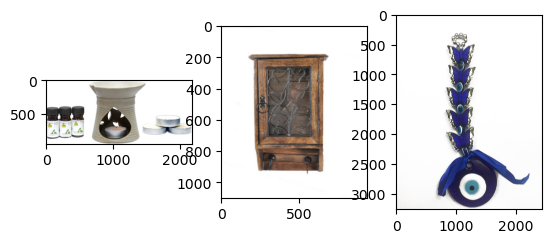

Kitchen & Dining


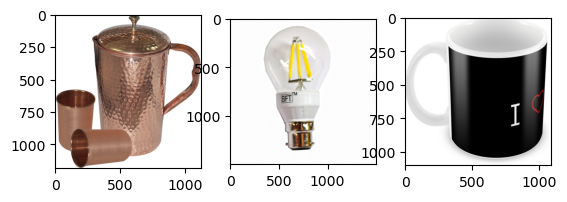

Beauty and Personal Care


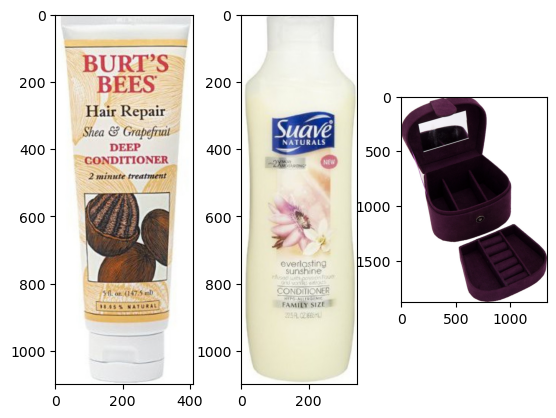

Computers


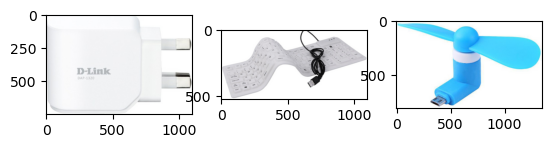

In [8]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["target"][i]==name]
    return list_image_name


list_Home_Furnishing=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Home Furnishing"]
list_Baby_Care=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Baby Care"]
list_Watches=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Watches"]
list_Home_Decor=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Home Decor & Festive Needs"]
list_Kitchen_Dining=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Kitchen & Dining"]
list_Beauty=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Beauty and Personal Care"]
list_Computers=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Computers"]


for name in target_list :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Etape 1 : étude de faisabilité


#### Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
2. un algorithme de type SIFT / ORB / SURF ;
3. un algorithme de type CNN Transfer Learning.

## Création du modèle pré-entraîné

In [9]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

In [10]:
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\Hankour\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA


In [11]:
from sklearn import manifold, decomposition
####
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)
(400, 4096)
(400, 292)

(1050, 4096)
(1050, 803)


(400, 292)

### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [12]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

C:\Users\Hankour\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de T-SNE :             8.90 secondes


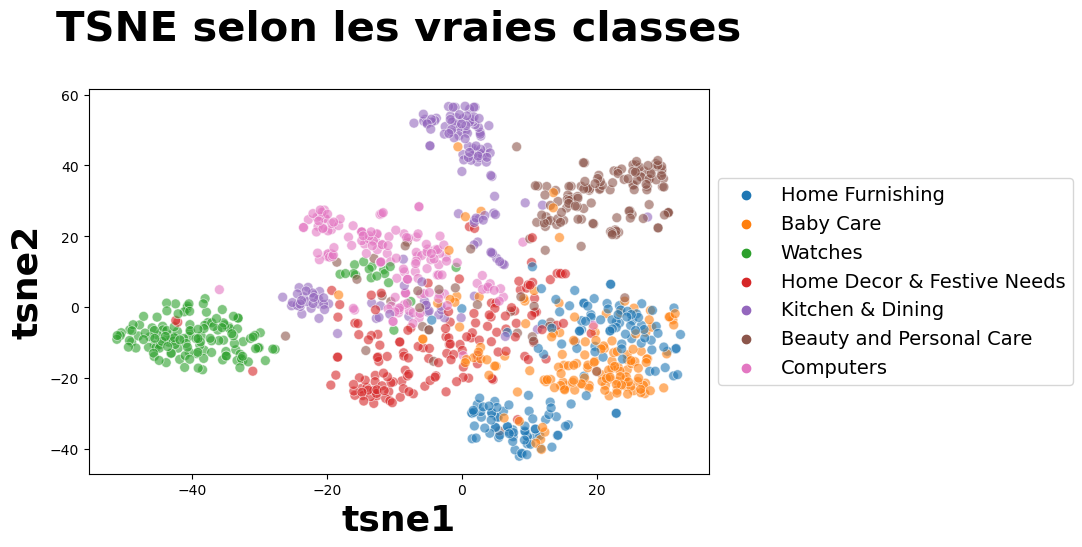

In [13]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["target"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center left', bbox_to_anchor=(1, 0.5)) 

plt.show()


### Clustering par KMeans

In [14]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

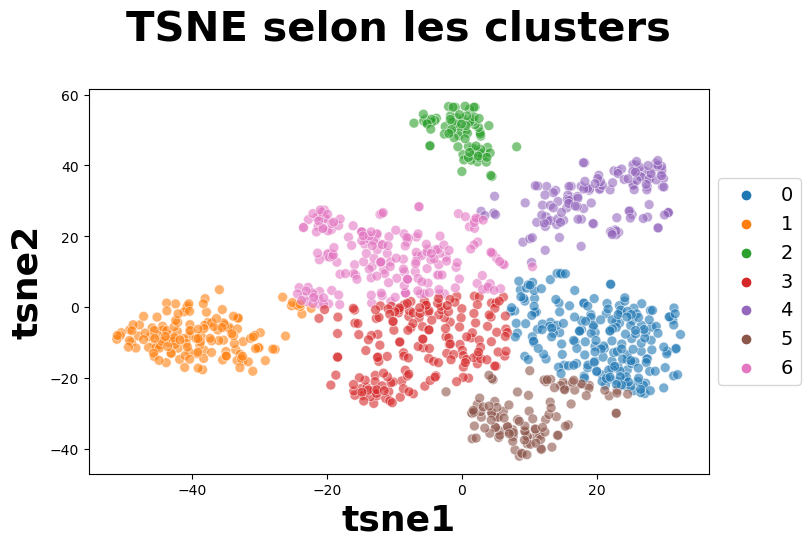

ARI :  0.4555679752185108


In [15]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center left', bbox_to_anchor=(1, 0.5)) 

plt.show()

labels = data["target_encode"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [16]:
df_tsne.loc[
    (df_tsne['class'] == 'Home Furnishing') &
    (df_tsne['cluster'] == 4)
].index

Int64Index([], dtype='int64')

In [17]:
df_tsne.loc[
    (df_tsne['class'] == 'Baby Care') &
    (df_tsne['cluster'] == 4)
].index

Int64Index([664, 670, 883, 996], dtype='int64')

tsne1      24.619022
tsne2     -24.609808
class      Baby Care
cluster            5
Name: 980, dtype: object


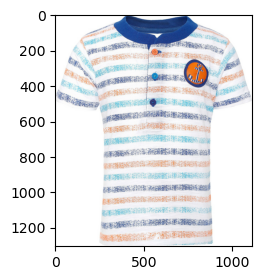

In [18]:
id = 980
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (3, 3))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()

tsne1              6.90064
tsne2           -35.149387
class      Home Furnishing
cluster                  5
Name: 34, dtype: object


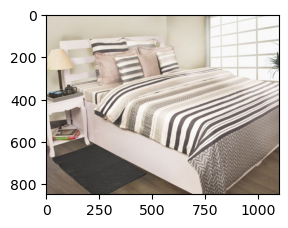

In [19]:
id = 34
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (3, 3))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()

### Analyse par classes


In [20]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 92   0   1  18   4  32   3]
 [ 11   1   1   7 118   1  11]
 [  1   1   0  23   1   0 124]
 [ 27   3   0 106   2   4   8]
 [ 75   0   0   3   0  71   1]
 [  1   8  78  20   7   0  36]
 [  0 133   0   2   0   0  15]]


In [21]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [22]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 6 5 3 1 4 2]
[[ 92   4   3  18  32   1   0]
 [ 11 118  11   7   1   1   1]
 [  1   1 124  23   0   0   1]
 [ 27   2   8 106   4   0   3]
 [ 75   0   1   3  71   0   0]
 [  1   7  36  20   0  78   8]
 [  0   0  15   2   0   0 133]]

              precision    recall  f1-score   support

           0       0.44      0.61      0.52       150
           1       0.89      0.79      0.84       150
           2       0.63      0.83      0.71       150
           3       0.59      0.71      0.64       150
           4       0.66      0.47      0.55       150
           5       0.97      0.52      0.68       150
           6       0.91      0.89      0.90       150

    accuracy                           0.69      1050
   macro avg       0.73      0.69      0.69      1050
weighted avg       0.73      0.69      0.69      1050



In [23]:
target_list

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

ARI :  0.4555679752185108


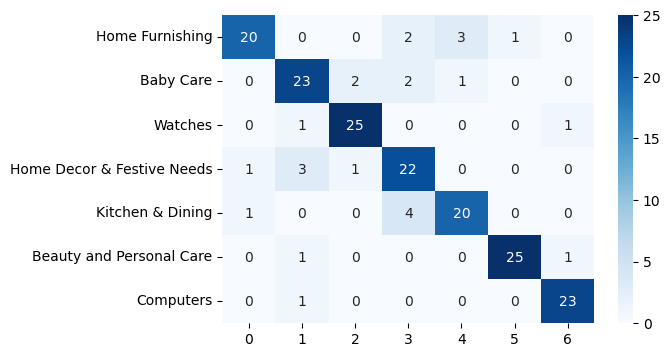

In [165]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in target_list],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Etape 2 Classification supervisée

In [100]:
data.head(3)

,target,image,image_path,target_encode
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,./Données/Flipkart\Images\55b85ea15a1536d46b71...,4
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,./Données/Flipkart\Images\7b72c92c2f6c40268628...,0
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,./Données/Flipkart\Images\64d5d4a258243731dc7b...,0


## Train test pour classification supervisée

In [126]:
# Train test split
data_train = data.sample(frac=0.7, random_state=45).copy()
data_test = data.loc[~data.index.isin(data_train.index)].copy()
# reset index
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [106]:
data.target.value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: target, dtype: int64

In [107]:
data_train.target.value_counts()

Beauty and Personal Care      112
Home Decor & Festive Needs    109
Kitchen & Dining              107
Computers                     106
Baby Care                     103
Home Furnishing               102
Watches                        96
Name: target, dtype: int64

In [108]:
data_test.target.value_counts()

Watches                       54
Home Furnishing               48
Baby Care                     47
Computers                     44
Kitchen & Dining              43
Home Decor & Festive Needs    41
Beauty and Personal Care      38
Name: target, dtype: int64

In [26]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x) # Nous 7 class

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [102]:
data

,target,image,image_path,target_encode
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,./Données/Flipkart\Images\55b85ea15a1536d46b71...,4
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,./Données/Flipkart\Images\7b72c92c2f6c40268628...,0
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,./Données/Flipkart\Images\64d5d4a258243731dc7b...,0
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,./Données/Flipkart\Images\d4684dcdc759dd9cdf41...,4
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,./Données/Flipkart\Images\6325b6870c54cd47be6e...,4
...,...,...,...,...
1045,Baby Care,958f54f4c46b53c8a0a9b8167d9140bc.jpg,./Données/Flipkart\Images\958f54f4c46b53c8a0a9...,0
1046,Baby Care,fd6cbcc22efb6b761bd564c28928483c.jpg,./Données/Flipkart\Images\fd6cbcc22efb6b761bd5...,0
1047,Baby Care,5912e037d12774bb73a2048f35a00009.jpg,./Données/Flipkart\Images\5912e037d12774bb73a2...,0
1048,Baby Care,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,./Données/Flipkart\Images\c3edc504d1b4f0ba6224...,0


In [113]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
# images_np = image_prep_fct(data_train)
# print(images_np.shape)
# images_np_test = image_prep_fct(data_test)
# print(images_np_test.shape)

In [118]:
images_np = image_prep_fct(data_train)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

C:\Users\Hankour\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(735, 224, 224, 3)
(315, 224, 224, 3)


In [130]:
X = images_np
y = to_categorical(data_train['target_encode'])

X_test = images_np_test
y_test = to_categorical(data_test['target_encode'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [131]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(551, 224, 224, 3)

In [132]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [133]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 7.7948 - accuracy: 0.3902
Epoch 1: val_loss improved from inf to 1.47450, saving model to .\model1_best_weights.h5
9/9 [==============================] - 47s 5s/step - loss: 7.7948 - accuracy: 0.3902 - val_loss: 1.4745 - val_accuracy: 0.7717
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.2484 - accuracy: 0.6806
Epoch 2: val_loss improved from 1.47450 to 1.11766, saving model to .\model1_best_weights.h5
9/9 [==============================] - 47s 5s/step - loss: 2.2484 - accuracy: 0.6806 - val_loss: 1.1177 - val_accuracy: 0.7880
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.5810 - accuracy: 0.7223
Epoch 3: val_loss improved from 1.11766 to 1.00322, saving model to .\model1_best_weights.h5
9/9 [==============================] - 47s 5s/step - loss: 1.5810 - accuracy: 0.7223 - val_loss: 1.0032 - val_accuracy: 0.8261
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 1.

In [134]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

18/18 [==============================] - 34s 2s/step - loss: 0.0028 - accuracy: 1.0000
Training Accuracy: 1.0000

6/6 [==============================] - 12s 2s/step - loss: 0.8907 - accuracy: 0.8315
Validation Accuracy:  0.8315


In [135]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8587
Test Accuracy       :  0.7714


In [142]:
# pip install plot_keras_history

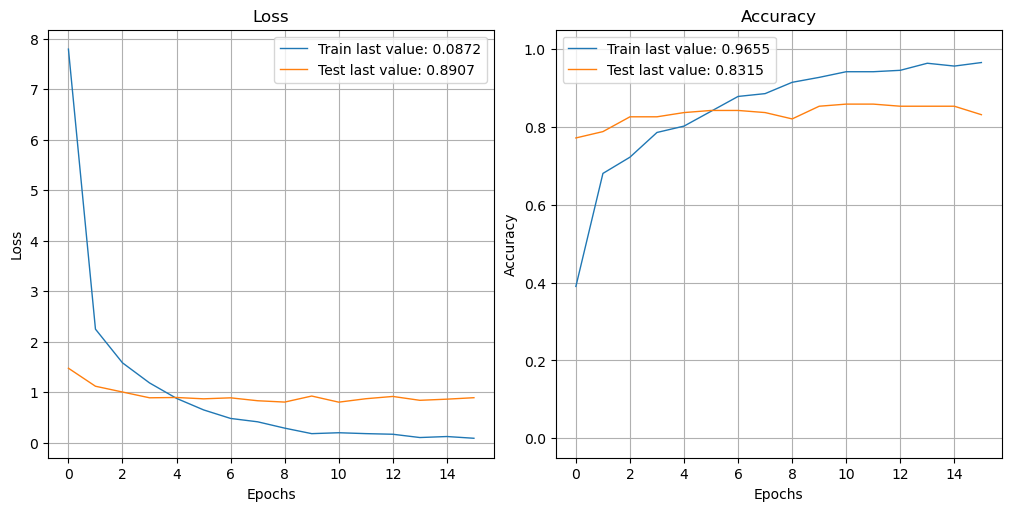

In [141]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [143]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 11s 2s/step
[1 2 2 3 3 6 1 3 3 5 4 1 1 3 3 1 0 0 0 1 4 5 3 0 6 1 6 6 5 4 0 2 0 4 1 3 3
 5 1 6 2 4 4 0 5 1 0 2 0 4 4 6 4 6 6 6 5 4 0 5 1 3 3 6 1 1 2 6 1 3 5 2 1 3
 3 5 1 3 6 0 2 5 6 5 2 0 1 5 4 3 6 1 2 3 3 4 2 4 2 4 0 0 3 6 2 5 4 4 0 0 4
 1 1 0 2 5 0 2 2 1 0 6 6 0 5 0 5 1 5 2 4 2 4 5 1 0 6 0 1 5 4 5 0 2 2 3 4 2
 6 5 5 3 5 3 0 1 4 4 5 3 2 5 1 6 6 3 5 5 6 6 2 2 2 4 2 1 3 6 2 3 3 0 4 1]

[1 2 2 3 3 6 2 1 1 5 4 1 1 3 3 1 0 5 0 1 4 5 3 0 6 1 6 6 5 4 0 2 0 4 1 1 3
 5 1 6 2 4 4 0 5 3 0 2 3 4 0 6 3 6 6 1 5 4 0 5 1 3 3 6 1 1 2 6 1 3 5 2 1 3
 2 5 1 3 6 0 2 5 6 5 2 4 1 5 4 3 6 1 2 3 3 3 1 3 2 4 0 0 3 6 2 1 4 4 0 0 4
 1 3 0 2 5 0 2 2 2 0 6 6 0 5 4 5 1 5 2 4 6 3 5 1 0 6 3 4 6 4 5 0 2 2 3 4 2
 6 5 5 0 5 3 4 1 4 4 5 3 2 5 1 6 6 3 5 5 6 6 2 2 2 4 2 1 3 6 2 3 3 0 4 1]


In [144]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[20  0  0  2  3  1  0]
 [ 0 23  2  2  1  0  0]
 [ 0  1 25  0  0  0  1]
 [ 1  3  1 22  0  0  0]
 [ 1  0  0  4 20  0  0]
 [ 0  1  0  0  0 25  1]
 [ 0  1  0  0  0  0 23]]


In [145]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[20  0  0  2  3  1  0]
 [ 0 23  2  2  1  0  0]
 [ 0  1 25  0  0  0  1]
 [ 1  3  1 22  0  0  0]
 [ 1  0  0  4 20  0  0]
 [ 0  1  0  0  0 25  1]
 [ 0  1  0  0  0  0 23]]

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        26
           1       0.79      0.82      0.81        28
           2       0.89      0.93      0.91        27
           3       0.73      0.81      0.77        27
           4       0.83      0.80      0.82        25
           5       0.96      0.93      0.94        27
           6       0.92      0.96      0.94        24

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



ARI :  0.6976471466628826


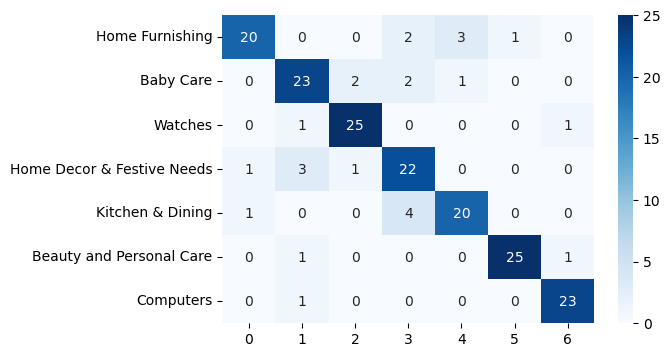

In [171]:
df_cm_supervised = pd.DataFrame(conf_mat, index = [label for label in target_list],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm_supervised, annot=True, cmap="Blues")
print("ARI : ", metrics.adjusted_rand_score(y_val_num, y_val_pred))

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [150]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [151]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [154]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='target',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [155]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 315 validated image filenames belonging to 7 classes.


In [156]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [157]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [158]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 3.9572 - accuracy: 0.4911

C:\Users\Hankour\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.06021, saving model to .\model2_best_weights.h5
25/25 [==============================] - 92s 4s/step - loss: 3.9572 - accuracy: 0.4911 - val_loss: 1.0602 - val_accuracy: 0.7366
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.4935 - accuracy: 0.6853
Epoch 2: val_loss improved from 1.06021 to 0.88805, saving model to .\model2_best_weights.h5
25/25 [==============================] - 94s 4s/step - loss: 1.4935 - accuracy: 0.6853 - val_loss: 0.8880 - val_accuracy: 0.7595
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.0733 - accuracy: 0.7119
Epoch 3: val_loss did not improve from 0.88805
25/25 [==============================] - 95s 4s/step - loss: 1.0733 - accuracy: 0.7119 - val_loss: 0.9680 - val_accuracy: 0.7557
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.8745 - accuracy: 0.7741 
Epoch 4: val_loss improved from 0.88805 to 0.77385, saving model to .\model2_best_weights.h5
25/25 [

In [159]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 79s 3s/step - loss: 0.0843 - accuracy: 0.9734
Training Accuracy   : 0.9734

9/9 [==============================] - 26s 3s/step - loss: 0.8601 - accuracy: 0.7977
Validation Accuracy :  0.7977


In [160]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8053
Test Accuracy       :  0.8921


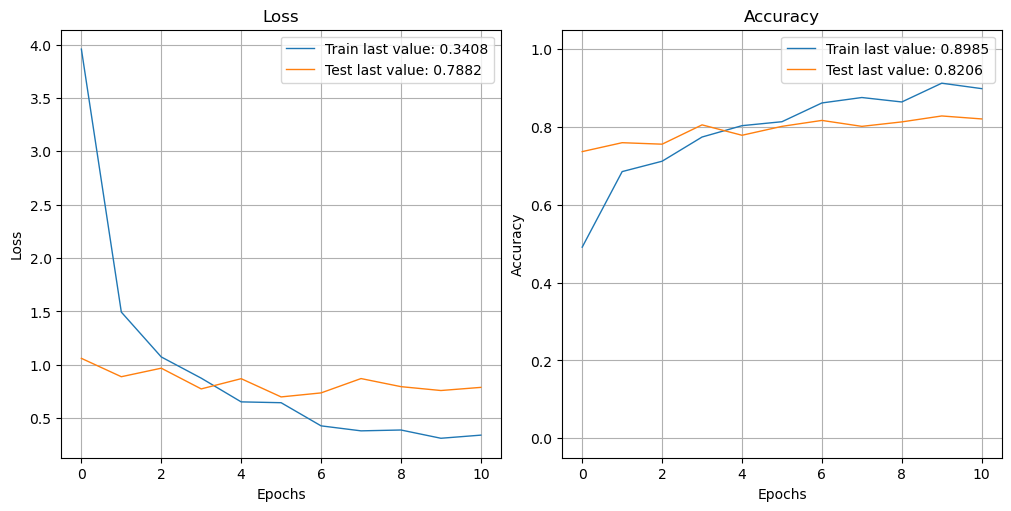

In [161]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()